In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import cv2 as cv

In [4]:
print(len(os.listdir('archive/CrashBest/')))

75000


In [5]:
import pandas as pd

df = pd.read_csv('archive/Crash_Table.csv')

df = pd.get_dummies(df, columns=['weather', 'timing'])

df = df.drop(['egoinvolve', 'youtubeID'], axis=1)

df.head()

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_47,frame_48,frame_49,frame_50,startframe,weather_Normal,weather_Rainy,weather_Snowy,timing_Day,timing_Night
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,285,True,False,False,True,False
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,646,True,False,False,True,False
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,972,True,False,False,True,False
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1257,True,False,False,True,False
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,462,False,False,True,True,False


In [6]:

df.astype(int)
df_sampled = df.sample(100, random_state=40)

In [7]:
PATH = "archive/CrashBest/"
IMG_WIDTH = 224
IMG_HEIGHT = 224


In [8]:
def get_file_name(video_name, frame_name):
  return f"C_{video_name:06}_{frame_name:02}.jpg"

def get_video_frame_paths(video_name):
  frame_paths = []
  for i in range (1, 51):
    frame_path = os.path.join(PATH, get_file_name(video_name, i))
    frame_paths.append(frame_path)
  return frame_paths

In [9]:
video_names = []
raw_images =[]
labels = []
features = []

for idx, row in df_sampled.iterrows():
  frame_paths = get_video_frame_paths(row["vidname"])
  if all(os.path.exists(frame_path) for frame_path in frame_paths):
    for frame_path in frame_paths:
      image = cv.imread(frame_path)
      image = cv.resize(image, (IMG_WIDTH, IMG_HEIGHT))
      raw_images.append(image)
      
    for i in range(1, 51):
      labels.append(row[f"frame_{i}"])
      feature_values = row[[
                "timing_Day", "timing_Night", 
                "weather_Normal", "weather_Rainy", "weather_Snowy"
            ]].values
      features.append(feature_values)
      video_names.append(row["vidname"])

print("Length of video_names: ", len(video_names))
print("Length of image_paths: ", len(raw_images))
print("Length of labels: ", len(labels))
print("Length of timings: ", len(features))

Length of video_names:  5000
Length of image_paths:  5000
Length of labels:  5000
Length of timings:  5000


In [10]:
def preprocess_image(image):
  gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  
  clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  image_clahe = clahe.apply(gray_image)
  
  return image_clahe

In [11]:
preprocessed_images = []

for image in raw_images:
  image = preprocess_image(image)
  preprocessed_images.append(image)

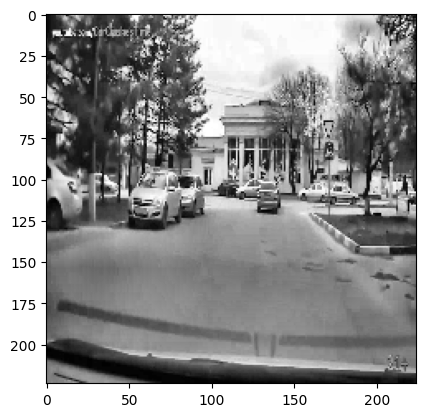

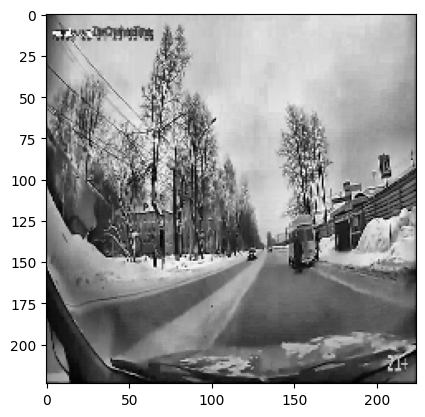

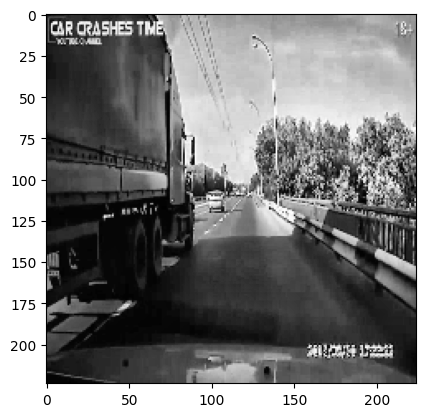

In [12]:
for i in range(1, 150, 50):
    plt.imshow(preprocessed_images[i], cmap='gray')
    plt.show()

In [13]:
SIFT = cv.SIFT_create()

# preprocessed_images = np.array(preprocessed_images).astype(np.float32) / 255.0

features = np.array(features)

descriptor_list = []

for preprocess_image in preprocessed_images:
    keypoints, descriptors = SIFT.detectAndCompute(preprocess_image, None)
    if descriptors is None:
        descriptors = np.zeros((1, 128))
    mean_description = np.mean(descriptors, axis=0)
    
    descriptor_list.append(mean_description)

sift_features =  np.array(descriptor_list)

combined_feature = np.hstack((sift_features, features))

labels = np.array(labels)

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(combined_feature, labels, test_size=0.2, random_state=348)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=348)

In [29]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression()
model.fit(x_train, y_train)

c:\Users\davea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 76.92%


In [31]:
from sklearn.metrics import accuracy_score

y_val_pred = model.predict(x_val)
accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 75.40%


In [32]:

from sklearn.metrics import classification_report, confusion_matrix
y_test_pred = model.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       351
           1       0.69      0.13      0.22       149

    accuracy                           0.72       500
   macro avg       0.71      0.55      0.53       500
weighted avg       0.72      0.72      0.65       500



Text(0.5, 1.0, 'Confusion Matrix')

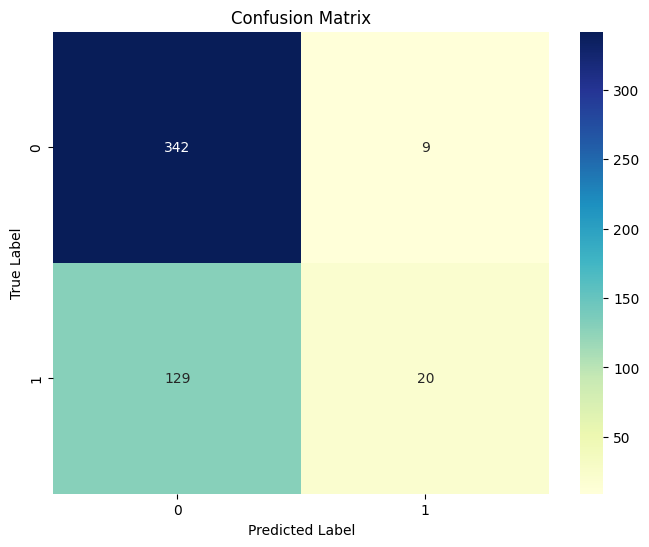

In [33]:
from seaborn import heatmap

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

# Add labels to the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')